In [2]:
from mmdet.apis import init_detector, inference_detector
import mmcv

/opt/p376/lib/python3.7/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [3]:
# config = 'mmdet_configs/configs/faster_rcnn/faster_rcnn_r50_fpn_2x_coco.py'
config = '../mmdetection/configs/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_iphone.py'

checkpoint = 'swin-merged-3-e19.pth'
# device = 'cuda:0'
device = 'cpu'

cfg = mmcv.Config.fromfile(config)
cfg.model.roi_head.bbox_head.num_classes = 20 # FRCNN
del cfg.model.roi_head.mask_head


In [4]:
model = init_detector(cfg, checkpoint, device)

load checkpoint from local path: swin-merged-3-e19.pth


/opt/p376/lib/python3.7/site-packages/mmdet/apis/inference.py:50: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [5]:
label_names = [
'IDX_FOREGROUND',
'IDX_IPHONE',
'IDX_IPAD',
'IDX_PRICE',
'IDX_POP',
'IDX_BP1',
'IDX_BP2',
'IDX_BP3',
'IDX_BP4',
'IDX_BP5',
'IDX_BP6',
'IDX_BP7',
'IDX_BP8',
'IDX_BP9',
'IDX_BP10',
'IDX_BP11',
'IDX_BP12',
'IDX_BP13',
'IDX_BP14',
'IDX_BP15'
]

In [6]:
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm

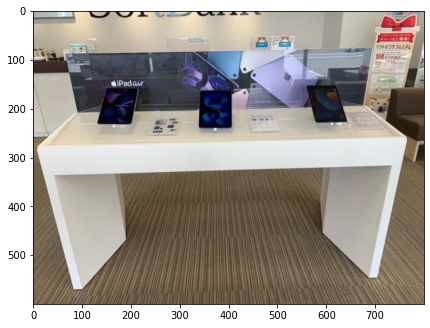

In [6]:
image = cv2.imread('./upload_2022_06_14_10_16_17-CSMD00054,9,11-1-B00004_p38.jpg')
scale = 600 / min(image.shape[:2])
image = cv2.resize(image,
                   None,
                   fx=scale,
                   fy=scale,
                   interpolation=cv2.INTER_AREA)
plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, ::-1])
plt.show()

/opt/p376/lib/python3.7/site-packages/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


0 IDX_FOREGROUND (15, 57, 776, 574) 0.9999753
2 IDX_IPAD (322, 145, 425, 252) 0.99998426
2 IDX_IPAD (119, 146, 227, 244) 0.9999132
2 IDX_IPAD (551, 144, 652, 238) 0.9967392
3 IDX_PRICE (225, 204, 310, 266) 0.9995183
3 IDX_PRICE (428, 200, 517, 257) 0.9992312
10 IDX_BP6 (221, 61, 615, 211) 0.8764043
17 IDX_BP13 (117, 68, 665, 216) 0.8971377


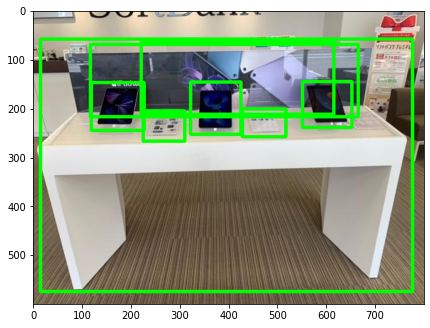

In [7]:
out = inference_detector(model, image)
res = image.copy()
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.5:
            break
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 5)

plt.figure(figsize=(7, 7))
plt.imshow(res[:, :, ::-1])
plt.show()

In [9]:
def generate_mask(image_size, grid_size, prob_thresh):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

In [10]:
def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) *
              255).astype(np.uint8)
    return masked

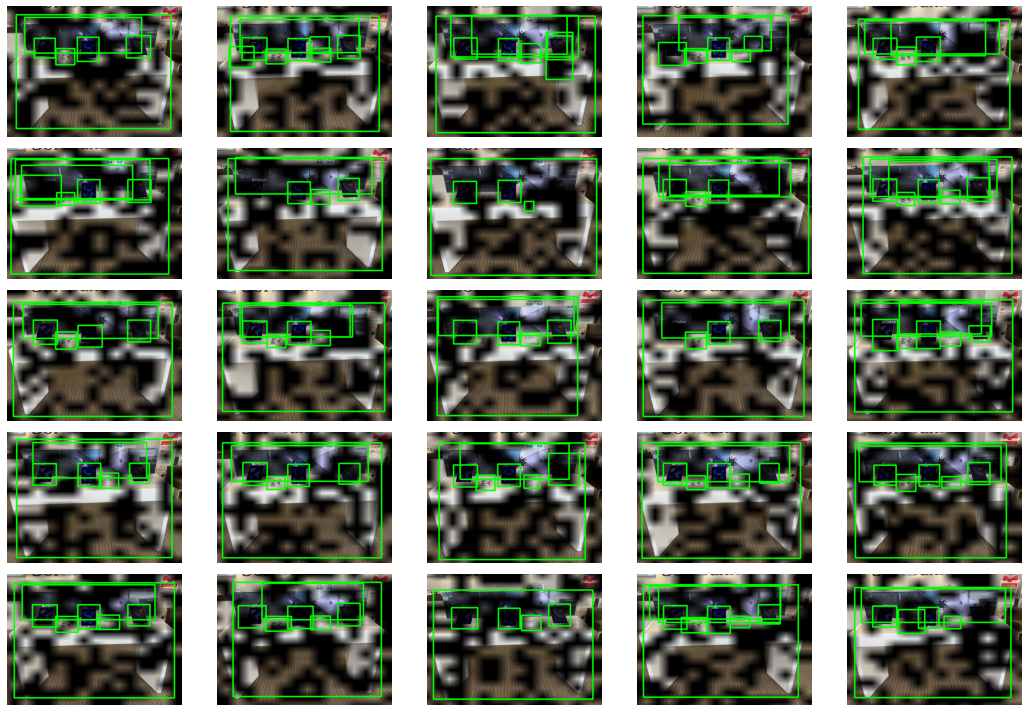

In [10]:
np.random.seed(0)

image_h, image_w = image.shape[:2]

images = []
for _ in range(25):
    mask = generate_mask(image_size=(image_w, image_h),
                         grid_size=(16, 16),
                         prob_thresh=0.5)
    masked = mask_image(image, mask)
    out = inference_detector(model, masked)
    res = masked.copy()
    for pred in out:
        for *box, score in pred:
            if score < 0.5:
                break
            box = tuple(np.round(box).astype(int).tolist())
            cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 5)
    images.append(res)

fig = plt.figure(figsize=(15, 10))
axes = fig.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axes[i][j].imshow(images[i * 5 + j][:, :, ::-1])
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [11]:
def iou(box1, box2):
    box1 = np.asarray(box1)
    box2 = np.asarray(box2)
    tl = np.vstack([box1[:2], box2[:2]]).max(axis=0)
    br = np.vstack([box1[2:], box2[2:]]).min(axis=0)
    intersection = np.prod(br - tl) * np.all(tl < br).astype(float)
    area1 = np.prod(box1[2:] - box1[:2])
    area2 = np.prod(box2[2:] - box2[:2])
    return intersection / (area1 + area2 - intersection)

In [12]:
def generate_saliency_map(image,
                          target_class_index,
                          target_box,
                          prob_thresh=0.5,
                          grid_size=(16, 16),
                          n_masks=5000,
                          seed=0):
    np.random.seed(seed)
    image_h, image_w = image.shape[:2]
    res = np.zeros((image_h, image_w), dtype=np.float32)
    for _ in tqdm.notebook.tqdm(range(n_masks)):
        mask = generate_mask(image_size=(image_w, image_h),
                             grid_size=grid_size,
                             prob_thresh=prob_thresh)
        masked = mask_image(image, mask)
        out = inference_detector(model, masked)
        pred = out[target_class_index]
        score = max([iou(target_box, box) * score for *box, score in pred],
                    default=0)
        res += mask * score
    return res

  0%|          | 0/1000 [00:00<?, ?it/s]

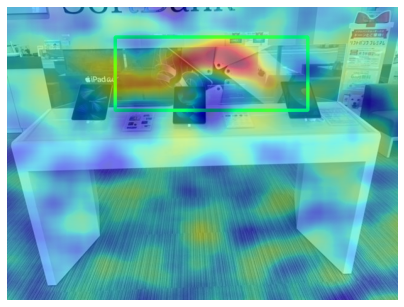

In [14]:
target_box = np.array([221, 61, 615, 211])
# target_box = np.array([211, 23, 500, 571])
cidx = 10
saliency_map = generate_saliency_map(image,
                                     target_class_index=cidx,
                                     target_box=target_box,
                                     prob_thresh=0.5,
                                     grid_size=(16, 16),
                                     n_masks=1000)

image_with_bbox = image.copy()
cv2.rectangle(image_with_bbox, tuple(target_box[:2]), tuple(target_box[2:]),
              (0, 255, 0), 5)
plt.figure(figsize=(7, 7))
plt.imshow(image_with_bbox[:, :, ::-1])
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

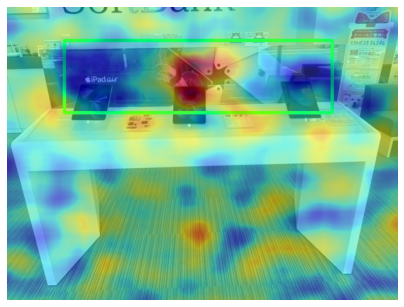

In [15]:
target_box = np.array([117, 68, 665, 216])
cidx = 17
saliency_map = generate_saliency_map(image,
                                     target_class_index=cidx,
                                     target_box=target_box,
                                     prob_thresh=0.5,
                                     grid_size=(16, 16),
                                     n_masks=1000)

image_with_bbox = image.copy()
cv2.rectangle(image_with_bbox, tuple(target_box[:2]), tuple(target_box[2:]),
              (0, 255, 0), 5)
plt.figure(figsize=(7, 7))
plt.imshow(image_with_bbox[:, :, ::-1])
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

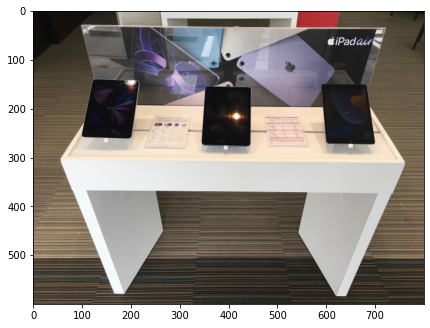

In [7]:
image = cv2.imread('upload_2022_06_13_14_02_07-542ALL127,9,4-1-B00001_p40.jpg')
scale = 600 / min(image.shape[:2])
image = cv2.resize(image,
                   None,
                   fx=scale,
                   fy=scale,
                   interpolation=cv2.INTER_AREA)
plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, ::-1])
plt.show()

/opt/p376/lib/python3.7/site-packages/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


0 IDX_FOREGROUND (54, 23, 762, 588) 0.99977905
2 IDX_IPAD (339, 146, 455, 286) 0.99998724
2 IDX_IPAD (582, 141, 707, 281) 0.99997485
2 IDX_IPAD (94, 136, 223, 268) 0.9999149
3 IDX_PRICE (219, 203, 334, 291) 0.9999746
3 IDX_PRICE (464, 203, 570, 289) 0.9999237
4 IDX_POP (109, 85, 189, 174) 0.8727341
10 IDX_BP6 (102, 23, 715, 207) 0.9996898


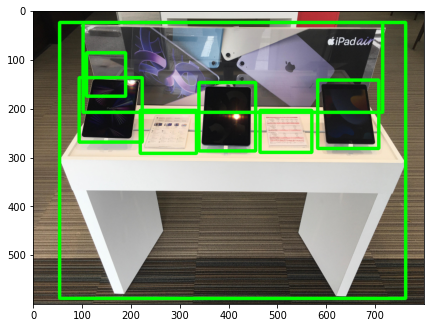

In [8]:
out = inference_detector(model, image)
res = image.copy()
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.5:
            break
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 5)

plt.figure(figsize=(7, 7))
plt.imshow(res[:, :, ::-1])
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

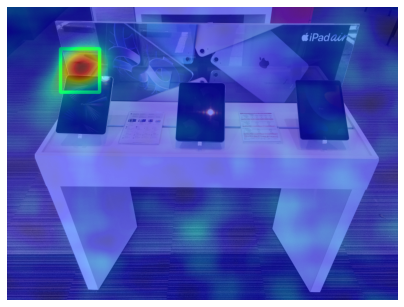

In [13]:
target_box = np.array([109, 85, 189, 174])
cidx = 4
saliency_map = generate_saliency_map(image,
                                     target_class_index=cidx,
                                     target_box=target_box,
                                     prob_thresh=0.5,
                                     grid_size=(16, 16),
                                     n_masks=1000)

image_with_bbox = image.copy()
cv2.rectangle(image_with_bbox, tuple(target_box[:2]), tuple(target_box[2:]),
              (0, 255, 0), 5)
plt.figure(figsize=(7, 7))
plt.imshow(image_with_bbox[:, :, ::-1])
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

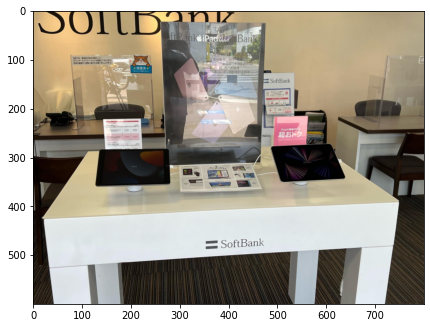

In [14]:
image = cv2.imread('upload_2022_06_25_13_19_39-TNC0S0051,9,9-1-B00003_p34_E.jpg')
scale = 600 / min(image.shape[:2])
image = cv2.resize(image,
                   None,
                   fx=scale,
                   fy=scale,
                   interpolation=cv2.INTER_AREA)
plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, ::-1])
plt.show()

0 IDX_FOREGROUND (4, 46, 772, 591) 0.99938905
2 IDX_IPAD (481, 266, 647, 358) 0.999956
2 IDX_IPAD (119, 271, 285, 366) 0.99994755
3 IDX_PRICE (296, 299, 471, 378) 0.995771
4 IDX_POP (481, 207, 568, 317) 0.99969053
4 IDX_POP (136, 211, 233, 299) 0.990476


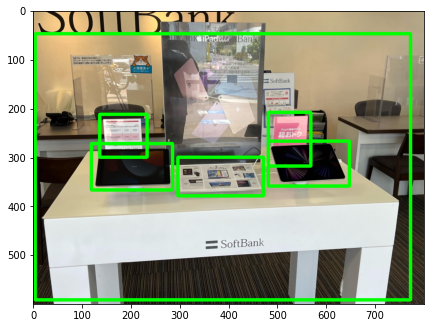

In [15]:
out = inference_detector(model, image)
res = image.copy()
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.5:
            break
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 5)

plt.figure(figsize=(7, 7))
plt.imshow(res[:, :, ::-1])
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

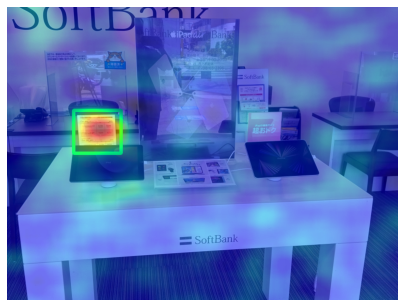

In [16]:
target_box = np.array([136, 211, 233, 299])
cidx = 4
saliency_map = generate_saliency_map(image,
                                     target_class_index=cidx,
                                     target_box=target_box,
                                     prob_thresh=0.5,
                                     grid_size=(16, 16),
                                     n_masks=1000)

image_with_bbox = image.copy()
cv2.rectangle(image_with_bbox, tuple(target_box[:2]), tuple(target_box[2:]),
              (0, 255, 0), 5)
plt.figure(figsize=(7, 7))
plt.imshow(image_with_bbox[:, :, ::-1])
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

In [17]:
target_box = np.array([481, 207, 568, 317])
cidx = 4
saliency_map = generate_saliency_map(image,
                                     target_class_index=cidx,
                                     target_box=target_box,
                                     prob_thresh=0.5,
                                     grid_size=(16, 16),
                                     n_masks=1000)

image_with_bbox = image.copy()
cv2.rectangle(image_with_bbox, tuple(target_box[:2]), tuple(target_box[2:]),
              (0, 255, 0), 5)
plt.figure(figsize=(7, 7))
plt.imshow(image_with_bbox[:, :, ::-1])
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]